# Authors:
##### Maria Musiał : 156062
##### Joanna Szczublińska : 156xxx
##### Wiktoria Szarzyńska : 156xxx

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset 
import torch
import torchvision.models as models
import PIL.Image
import string
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import cv2
from torchvision.transforms.functional import to_pil_image

In [32]:
class ApplyCLAHE:
    """
    Konwersja RGB → YUV, zastosowanie CLAHE na kanale Y, powrót do RGB.
    """
    def __init__(self, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img: PIL.Image.Image) -> PIL.Image.Image:
        # Konwersja PIL.Image → numpy (RGB, uint8)
        img_np = np.array(img)
        # RGB → YUV
        img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
        # CLAHE na kanale Y
        y_channel = img_yuv[:, :, 0]
        img_yuv[:, :, 0] = self.clahe.apply(y_channel)
        # YUV → RGB
        img_rgb_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return PIL.Image.fromarray(img_rgb_eq)

### Defining dataset class

In [33]:
# root_dir = "put_jetbot_dataset/dataset/"
# samples=[]


class JetBotDataset(Dataset):
    """
    Dataset that reads images and forward, left values from csv (from root_dir), uses transformations externally defined.
    Returns image(rgb), [forward, left] tensor
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        folders = [name for name in os.listdir(root_dir)
           if os.path.isdir(os.path.join(root_dir, name))]

        for folder_name in folders:
            file_name = folder_name + ".csv"
            csv_path = os.path.join(root_dir, file_name)
            folder_path = os.path.join(root_dir, folder_name)
            # print(folder_name, file_name, csv_path, folder_path)

            if not os.path.exists(csv_path):
                print(f"Warning: CSV file {csv_path} not found, skipping folder {folder_name}")
                continue
            
            try:
                df = pd.read_csv(csv_path, header=None, dtype={"0":"int32", "1":"float64", "2":"float64"})
                df.columns = ["filename", "forward", "left"]

                for _, row in df.iterrows():
                    img_path = os.path.join(folder_path, str(row['filename'])[:-2].zfill(4)+".jpg")     # row[filename gives number of photo]; zfill gives leading zeros
                    if not os.path.exists(img_path):
                        print(f"Warnign: Image file {img_path} not found.")
                        continue
                    self.samples.append((img_path, float(row["forward"]), float(row["left"])))
            except Exception as e:
                print(f"Error processing {csv_path}: e")
                
        print(f"Loaded {len(self.samples)} samples from {len(folders)} folders")

                
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, forward, left = self.samples[idx]
        
        try:
            image = PIL.Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor([forward, left], dtype=torch.float32)
            # return image, torch.tensor([forward, left], dtype=torch.float32)    

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3,224,224))
            return placeholder, torch.tensor([0.0, 0.0], dtype=torch.float32)
    
    
#
from torchvision import transforms

def get_transforms(augument=True):
    """Create transformations for training and validation/test datasets.
    For JetBot camera images (usually 224x224 RGB).
    
    Args:
        augment (bool): If True, apply data augmentation for training.
        
    Returns:
        torchvision.transforms.Compose object
    """
    common_transforms = [
        ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
        transforms.Resize((224, 224)),  # resize all images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
                             std=[0.229, 0.224, 0.225]),
    ]

    if augument:
        train_transforms = [
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
            transforms.RandomRotation(degrees=2),
            # transforms.RandomHorizontalFlip(p=0.5),

            # Optional realistic distortions:
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Simulate camera blur
            # transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Simulate lens distortion
            # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),  # Subtle motion

            *common_transforms
        ]
        return transforms.Compose( train_transforms)
    else:
        return transforms.Compose( common_transforms)


In [34]:
from torch.utils.data import Dataset

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.subset)


In [35]:
from torch.utils.data import random_split, DataLoader

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=32):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Transforms
    train_transform = get_transforms(augument=True)
    val_test_transform = get_transforms(augument=False)

    # Load full dataset
    base_dataset = JetBotDataset(root_dir, transform=None)
    total_size = len(base_dataset)

    train_len = int(total_size * train_ratio)
    val_len = int(total_size * val_ratio)
    test_len = total_size - train_len - val_len

    generator = torch.Generator().manual_seed(42)
    train_base, val_base, test_base = random_split(base_dataset, [train_len, val_len, test_len], generator=generator)

    # Wrap with transforms
    train_set = SubsetWithTransform(train_base, transform=train_transform)
    val_set = SubsetWithTransform(val_base, transform=val_test_transform)
    test_set = SubsetWithTransform(test_base, transform=val_test_transform)

    return {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size),
        "test": DataLoader(test_set, batch_size=batch_size)
    }



In [36]:
data = create_datasets(root_dir = "dataset/", batch_size=32)
train_loader = data["train"]
val_loader = data["val"]
test_loader = data["test"]

Warnign: Image file dataset/1652876206.2541456\0008.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0009.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0010.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0011.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0012.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0013.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0014.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0015.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0019.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0020.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0021.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0022.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0023.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0024.jpg not found.
Warnign: Image file dataset/1652876206.2541456\0025.jpg not fo

In [37]:
import matplotlib.pyplot as plt
import torchvision

# Reverse normalization: ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def unnormalize(tensor):
    for t, m, s in zip(tensor, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    return tensor


def show_batch(loader, n_images=8):
    batch = next(iter(loader))  # Get one batch
    images, labels = batch

    images = images[:n_images]  # limit to first N
    labels = labels[:n_images]

    # Unnormalize
    images = torch.stack([unnormalize(img.clone()) for img in images])

    # Create grid
    grid_img = torchvision.utils.make_grid(images, nrow=4)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Training Batch (Augmented + Normalized)")
    plt.axis("off")
    plt.show()

    # Optional: print labels (steering + throttle)
    for i, (fwd, left) in enumerate(labels):
        print(f"Sample {i}: forward = {fwd:.2f}, left = {left:.2f}")



In [38]:
# show_batch(train_loader)


In [39]:
# def count_control_classes(data_loader):
#     left_count = 0
#     straight_count = 0
#     right_count = 0

#     for images, labels in data_loader:
#         # labels[:, 1] is the "left" value (since [forward, left])
#         left_values = labels[:, 1]

#         left_count += (left_values < 0).sum().item()
#         straight_count += (left_values == 0).sum().item()
#         right_count += (left_values > 0).sum().item()

#     total = left_count + straight_count + right_count
#     print(f"Total samples: {total}")
#     print(f"Left (< 0): {left_count}")
#     print(f"Straight (= 0): {straight_count}")
#     print(f"Right (> 0): {right_count}")


In [40]:
# count_control_classes(train_loader)

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class ModifiedNvidiaNetwork(nn.Module):
    def __init__(self):
        super(ModifiedNvidiaNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  # Add adaptive pooling

        feature_size = 128 * 4 * 4  # matches avgpool output

        self.fc1 = nn.Linear(feature_size, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.avgpool(x)  # ensure fixed spatial size

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.output(x)

        return x


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model = NvidiaPaperNetwork().to(device)
model = ModifiedNvidiaNetwork().to(device)

Using device: cpu


In [43]:
print("\nModel architecture:")
print(model)

# Count number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")



Model architecture:
ModifiedNvidiaNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 365,442


In [44]:
def weighted_mse_loss(pred, target):
    # Weight is higher for target values further from 0
    # You can tune the exponent (e.g., 2 or 3) to adjust steepness
    weights = 1.0 + (target.abs() ** 2)  # e.g., 1 + |target|^2

    mse = (pred - target) ** 2
    weighted_mse = weights * mse
    return weighted_mse.mean()


In [45]:
def training(model, train_loader, val_loader, device, weighted_mse_loss, epochs=100):
    """
    Training loop with model saving
    """
    best_model_path = 'best_model_jetbot.pth'
    best_loss = 1e9
    patience = 17
    patience_counter = 0    
    
    optimizer = optim.Adam(model.parameters(), lr =0.0003, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
        
        model.train()
        train_loss = 0.0
        
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, targets in train_iterator:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = weighted_mse_loss(outputs, targets)
            
            train_loss += float(loss)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_iterator.set_postfix(loss=float(loss))
            
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
            for images, targets in val_iterator:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                loss = weighted_mse_loss(outputs, targets)      
                val_loss += float(loss)
                
                # Update progress bar
                val_iterator.set_postfix(loss=float(loss))
                
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            torch.save(model.state_dict(), best_model_path)
            best_loss = val_loss
            patience_counter = 0
            print(f"New best model saved with val loss: {val_loss:.6f}")
        else:
            patience_counter += 1
            
    print(f"Training completed. Best val loss: {best_loss:.6f}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    
    return best_model_path

In [46]:
# (outputs, targets)
            
#             train_loss += float(loss)
#             loss.backward()
            
#             # Gradient clipping to prevent exploding gradients
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
#             train_iterator.set_postfix(loss=float(loss))
            
#         train_loss /= len(train_loader)
#         train_loss_history.append(train_loss)
        
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
#             for images, targets in val_iterator:
#                 images = images.to(device)
#                 targets = targets.to(device)
#                 outputs = model(images)
#                 loss = F.mse_loss(outputs, targets)      
#                 val_loss += float(loss)
                
#                 # Update progress bar
#                 val_iterator.set_postfix(loss=float(loss))
                
#         val_loss /= len(val_loader)
#         val_loss_history.append(val_loss)
        
#         # Update learning rate based on validation loss
#         scheduler.step(val_loss)
            
#         print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")
        
#         # Save best model
#         if val_loss < best_loss:
#             torch.save(model.state_dict(), best_model_path)
#             best_loss = val_loss
#             patience_counter = 0
#             print(f"New best model saved with val loss: {val_loss:.6f}")
#         else:
#             patience_counter += 1
            
#     print(f"Training completed. Best val loss: {best_loss:.6f}")
    
#     # Plot loss curves
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_loss_history, label='Train Loss')
#     plt.plot(val_loss_history, label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Val Loss')
#     plt.legend()
#     plt.savefig('loss_curves.png')
#     plt.show()
    
#     return best_model_path

Epoch 1/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, loss=0.489]


Epoch 1/100 - Train loss: 0.805239 - Val loss: 0.470997
New best model saved with val loss: 0.470997


Epoch 2/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, loss=0.393]


Epoch 2/100 - Train loss: 0.531030 - Val loss: 0.367383
New best model saved with val loss: 0.367383


Epoch 3/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=0.492]


Epoch 3/100 - Train loss: 0.465484 - Val loss: 0.433116


Epoch 4/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.456]


Epoch 4/100 - Train loss: 0.429213 - Val loss: 0.400137


Epoch 5/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s, loss=0.525]


Epoch 5/100 - Train loss: 0.443098 - Val loss: 0.465526


Epoch 6/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.80it/s, loss=0.443]


Epoch 6/100 - Train loss: 0.436175 - Val loss: 0.393049


Epoch 7/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s, loss=0.432]


Epoch 7/100 - Train loss: 0.414103 - Val loss: 0.385749


Epoch 8/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s, loss=0.484]


Epoch 8/100 - Train loss: 0.444800 - Val loss: 0.428279


Epoch 9/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s, loss=0.45] 


Epoch 9/100 - Train loss: 0.397009 - Val loss: 0.394462


Epoch 10/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.59it/s, loss=0.475]


Epoch 10/100 - Train loss: 0.420922 - Val loss: 0.415176


Epoch 11/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s, loss=0.444]


Epoch 11/100 - Train loss: 0.403056 - Val loss: 0.397046


Epoch 12/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s, loss=0.425]


Epoch 12/100 - Train loss: 0.394943 - Val loss: 0.384046


Epoch 13/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s, loss=0.416]


Epoch 13/100 - Train loss: 0.420829 - Val loss: 0.381442


Epoch 14/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s, loss=0.433]


Epoch 14/100 - Train loss: 0.415311 - Val loss: 0.394694


Epoch 15/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.94it/s, loss=0.426]


Epoch 15/100 - Train loss: 0.389657 - Val loss: 0.384117


Epoch 16/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.93it/s, loss=0.421]


Epoch 16/100 - Train loss: 0.400045 - Val loss: 0.374193


Epoch 17/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s, loss=0.45] 


Epoch 17/100 - Train loss: 0.405584 - Val loss: 0.403353


Epoch 18/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=0.395]


Epoch 18/100 - Train loss: 0.412211 - Val loss: 0.360735
New best model saved with val loss: 0.360735


Epoch 19/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.45] 


Epoch 19/100 - Train loss: 0.390296 - Val loss: 0.410574


Epoch 20/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=0.361]


Epoch 20/100 - Train loss: 0.395618 - Val loss: 0.328514
New best model saved with val loss: 0.328514


Epoch 21/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.61it/s, loss=0.451]


Epoch 21/100 - Train loss: 0.382471 - Val loss: 0.410533


Epoch 22/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=0.339]


Epoch 22/100 - Train loss: 0.358310 - Val loss: 0.310148
New best model saved with val loss: 0.310148


Epoch 23/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.39] 


Epoch 23/100 - Train loss: 0.363301 - Val loss: 0.350604


Epoch 24/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.44it/s, loss=0.325]


Epoch 24/100 - Train loss: 0.340979 - Val loss: 0.300092
New best model saved with val loss: 0.300092


Epoch 25/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.84it/s, loss=0.314]


Epoch 25/100 - Train loss: 0.341124 - Val loss: 0.295740
New best model saved with val loss: 0.295740


Epoch 26/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s, loss=0.314]


Epoch 26/100 - Train loss: 0.312449 - Val loss: 0.277755
New best model saved with val loss: 0.277755


Epoch 27/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s, loss=0.258]


Epoch 27/100 - Train loss: 0.288945 - Val loss: 0.252138
New best model saved with val loss: 0.252138


Epoch 28/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s, loss=0.184]


Epoch 28/100 - Train loss: 0.262617 - Val loss: 0.175121
New best model saved with val loss: 0.175121


Epoch 29/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s, loss=0.201]


Epoch 29/100 - Train loss: 0.306159 - Val loss: 0.205121


Epoch 30/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=0.178]


Epoch 30/100 - Train loss: 0.233322 - Val loss: 0.172664
New best model saved with val loss: 0.172664


Epoch 31/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, loss=0.143]


Epoch 31/100 - Train loss: 0.227423 - Val loss: 0.165982
New best model saved with val loss: 0.165982


Epoch 32/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s, loss=0.192]


Epoch 32/100 - Train loss: 0.254322 - Val loss: 0.176618


Epoch 33/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, loss=0.131]


Epoch 33/100 - Train loss: 0.202955 - Val loss: 0.146750
New best model saved with val loss: 0.146750


Epoch 34/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s, loss=0.161]


Epoch 34/100 - Train loss: 0.209240 - Val loss: 0.157878


Epoch 35/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s, loss=0.133]


Epoch 35/100 - Train loss: 0.246744 - Val loss: 0.159292


Epoch 36/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s, loss=0.125]


Epoch 36/100 - Train loss: 0.243299 - Val loss: 0.135102
New best model saved with val loss: 0.135102


Epoch 37/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.58it/s, loss=0.131]


Epoch 37/100 - Train loss: 0.225207 - Val loss: 0.154236


Epoch 38/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s, loss=0.16] 


Epoch 38/100 - Train loss: 0.227100 - Val loss: 0.168787


Epoch 39/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s, loss=0.145]


Epoch 39/100 - Train loss: 0.224989 - Val loss: 0.154144


Epoch 40/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, loss=0.128]


Epoch 40/100 - Train loss: 0.209428 - Val loss: 0.149014


Epoch 41/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s, loss=0.166]


Epoch 41/100 - Train loss: 0.236027 - Val loss: 0.163811


Epoch 42/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s, loss=0.162]


Epoch 42/100 - Train loss: 0.209486 - Val loss: 0.170547


Epoch 43/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s, loss=0.153]


Epoch 43/100 - Train loss: 0.199501 - Val loss: 0.157885


Epoch 44/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s, loss=0.168]


Epoch 44/100 - Train loss: 0.209255 - Val loss: 0.164910


Epoch 45/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s, loss=0.107]


Epoch 45/100 - Train loss: 0.195686 - Val loss: 0.122566
New best model saved with val loss: 0.122566


Epoch 46/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, loss=0.175]


Epoch 46/100 - Train loss: 0.207731 - Val loss: 0.176455


Epoch 47/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.13] 


Epoch 47/100 - Train loss: 0.199198 - Val loss: 0.141016


Epoch 48/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s, loss=0.149]


Epoch 48/100 - Train loss: 0.197970 - Val loss: 0.141071


Epoch 49/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s, loss=0.196]


Epoch 49/100 - Train loss: 0.196460 - Val loss: 0.195946


Epoch 50/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s, loss=0.101]


Epoch 50/100 - Train loss: 0.211872 - Val loss: 0.119434
New best model saved with val loss: 0.119434


Epoch 51/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s, loss=0.167]


Epoch 51/100 - Train loss: 0.199709 - Val loss: 0.162680


Epoch 52/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=0.148]


Epoch 52/100 - Train loss: 0.212696 - Val loss: 0.146019


Epoch 53/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.12] 


Epoch 53/100 - Train loss: 0.195101 - Val loss: 0.130515


Epoch 54/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=0.144]


Epoch 54/100 - Train loss: 0.169121 - Val loss: 0.141149


Epoch 55/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s, loss=0.147]


Epoch 55/100 - Train loss: 0.187902 - Val loss: 0.147949


Epoch 56/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s, loss=0.116]


Epoch 56/100 - Train loss: 0.164386 - Val loss: 0.126633


Epoch 57/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=0.217]


Epoch 57/100 - Train loss: 0.185584 - Val loss: 0.201041


Epoch 58/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s, loss=0.109]


Epoch 58/100 - Train loss: 0.193208 - Val loss: 0.114025
New best model saved with val loss: 0.114025


Epoch 59/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, loss=0.212]


Epoch 59/100 - Train loss: 0.200544 - Val loss: 0.207021


Epoch 60/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s, loss=0.129]


Epoch 60/100 - Train loss: 0.165998 - Val loss: 0.130403


Epoch 61/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s, loss=0.181]


Epoch 61/100 - Train loss: 0.151452 - Val loss: 0.177246


Epoch 62/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s, loss=0.152]


Epoch 62/100 - Train loss: 0.192660 - Val loss: 0.154999


Epoch 63/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=0.198]


Epoch 63/100 - Train loss: 0.171429 - Val loss: 0.186540


Epoch 64/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s, loss=0.144]


Epoch 64/100 - Train loss: 0.180312 - Val loss: 0.151670


Epoch 65/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, loss=0.17] 


Epoch 65/100 - Train loss: 0.167938 - Val loss: 0.171903


Epoch 66/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s, loss=0.189]


Epoch 66/100 - Train loss: 0.184089 - Val loss: 0.162022


Epoch 67/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, loss=0.154]


Epoch 67/100 - Train loss: 0.167120 - Val loss: 0.163833


Epoch 68/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s, loss=0.16] 


Epoch 68/100 - Train loss: 0.164554 - Val loss: 0.166751


Epoch 69/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s, loss=0.178]


Epoch 69/100 - Train loss: 0.162322 - Val loss: 0.165306


Epoch 70/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s, loss=0.198]


Epoch 70/100 - Train loss: 0.183937 - Val loss: 0.187519


Epoch 71/100 [Test]: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, loss=0.164]


Epoch 71/100 - Train loss: 0.163167 - Val loss: 0.161787


Epoch 72/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s, loss=0.164]


Epoch 72/100 - Train loss: 0.167760 - Val loss: 0.165714


Epoch 73/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s, loss=0.174]


Epoch 73/100 - Train loss: 0.160152 - Val loss: 0.171823


Epoch 74/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s, loss=0.253]


Epoch 74/100 - Train loss: 0.169309 - Val loss: 0.228772


Epoch 75/100 [Test]: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s, loss=0.195]


Epoch 75/100 - Train loss: 0.167452 - Val loss: 0.180366
Early stopping triggered at epoch 76.
Training completed. Best val loss: 0.114025


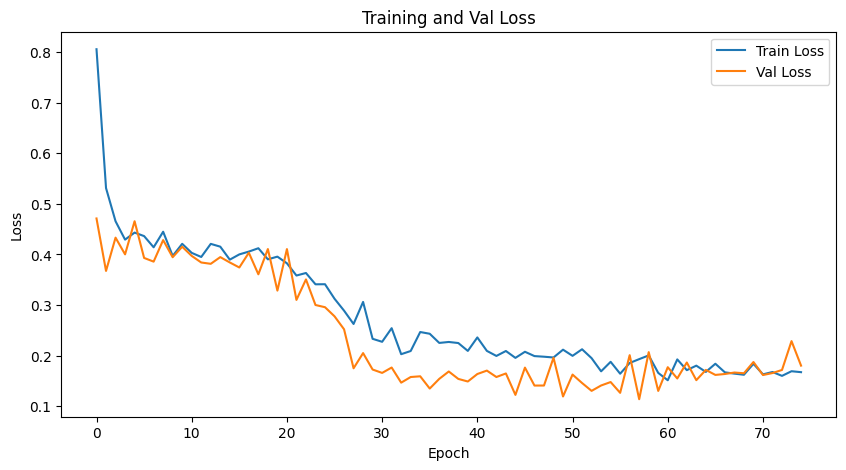

In [47]:
best_model_path = training(model, train_loader, test_loader, device, weighted_mse_loss, epochs=100)

# Load the best model
# model.load_state_dict(torch.load(best_model_path))

In [48]:
def visualize_predictions(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            for i in range(min(n, images.size(0))):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                true = labels[i].cpu().numpy()
                pred = outputs[i].cpu().numpy()
                
                plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
                plt.title(f"GT: {true.round(2)} | Pred: {pred.round(2)}")
                plt.axis("off")
                plt.show()

                shown += 1
                if shown >= n:
                    return


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


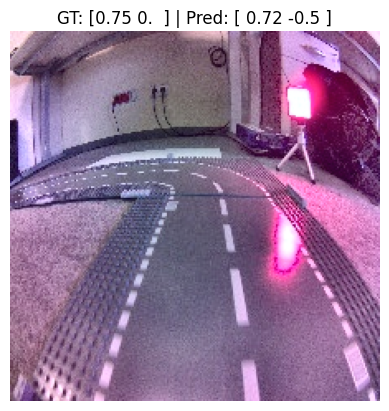

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


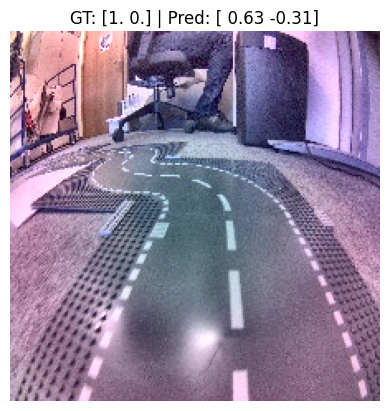

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


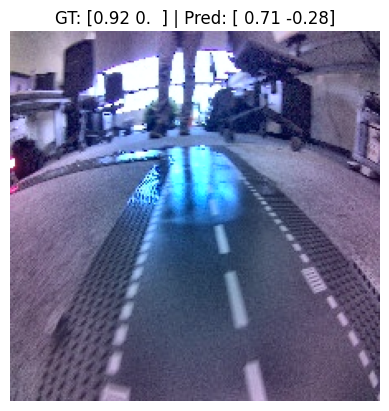

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


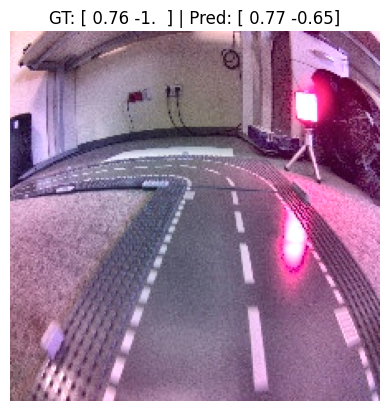

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].


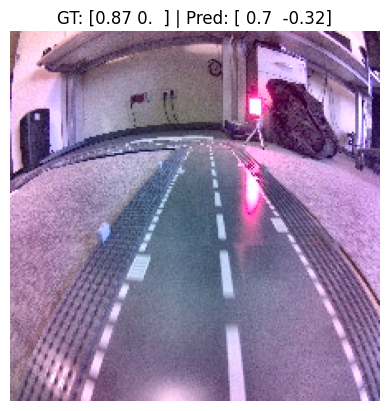

In [49]:
model.load_state_dict(torch.load(best_model_path))

visualize_predictions(model, test_loader)


In [50]:
import matplotlib.pyplot as plt
import torch

def plot_predictions_vs_ground_truth(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu', max_points=500):
    model.eval()
    model.to(device)

    true_left = []
    true_forward = []
    pred_left = []
    pred_forward = []

    with torch.no_grad():
        count = 0
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            # Collect true and predicted values
            true_left.extend(targets[:, 1].cpu().numpy())
            true_forward.extend(targets[:, 0].cpu().numpy())

            # Round predicted left before collecting
            pred_left.extend(outputs[:, 1].cpu().numpy())
            pred_forward.extend(outputs[:, 0].cpu().numpy())

            count += images.size(0)
            if count >= max_points:
                break

    plt.figure(figsize=(8, 8))
    plt.scatter(true_left, true_forward, color='blue', alpha=0.5, label='True')
    plt.scatter(pred_left, pred_forward, color='red', alpha=0.5, label='Predicted ')

    plt.xlabel('Left Value')
    plt.ylabel('Forward Value')
    plt.title('True vs Predicted: Left vs Forward')
    plt.legend()
    plt.grid(True)
    plt.show()


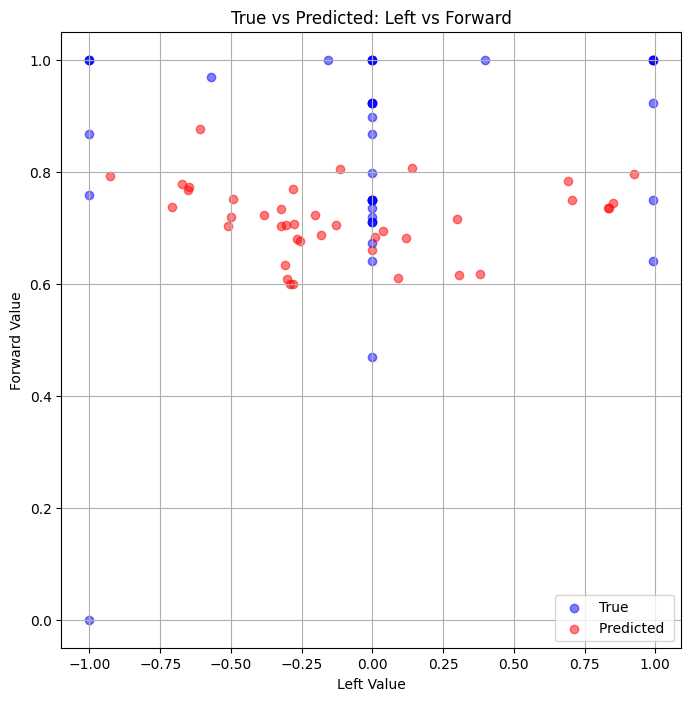

In [51]:
plot_predictions_vs_ground_truth(model, test_loader)


In [52]:
import torch
import onnx

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval()
model.to(device)

# Create a dummy input tensor with the same shape as  the model expects
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # batch size 1

onnx_model_path = "model_jetbot.onnx"

torch.onnx.export(
    model,                   # model being run
    dummy_input,             # model input (or a tuple for multiple inputs)
    onnx_model_path,         # where to save the model
    opset_version=11,        # ONNX version
    input_names=['input'],   # input layer names
    output_names=['output'], # output layer names
    dynamic_axes={
        'input': {0: 'batch_size'},    # variable length axes
        'output': {0: 'batch_size'}
    },
    do_constant_folding=True,  # optimization
    verbose=False              # set to True if you want detailed export log
)

# Load and check the ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

print("Model has been successfully exported to ONNX format!")


Model has been successfully exported to ONNX format!


In [ ]:
import cv2
import numpy as np
import onnxruntime as rt
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class AI:
    def __init__(self, model_path: str):
        # self.sess = rt.InferenceSession(model_path, providers=[
        #     'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name

        # Define same preprocessing used in training
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy to PIL
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert to tensor and rescale to [0, 1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        """a
        Preprocess BGR image to match model input.
        Converts BGR to RGB, applies resizing, normalization, etc.
        Returns a numpy array of shape (1, 3, 224, 224) with dtype float32.
        """
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)  # Apply transforms
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        return img_tensor.numpy().astype(np.float32)

    def postprocess(self, detections: np.ndarray) -> np.ndarray:
        """
        Postprocess model outputs.
        Converts to 1D numpy array if needed.
        """
        return detections.squeeze()  # Should be shape (2,)

    def predict(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)

        assert inputs.dtype == np.float32
        assert inputs.shape == (1, 3, 224, 224)

        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        outputs = self.postprocess(detections)

        assert outputs.dtype == np.float32
        assert outputs.shape == (2,)
        assert outputs.max() < 1.0
        assert outputs.min() > -1.0

        return outputs


def check(img_name, model):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        image_path = f'camera/{img_name}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image '{img_name}' not found in camera/ directory!")

    # model_path = 'model_jetbot.onnx'
    # model.load_state_dict(torch.load(best_model_path))

    # ai = AI(model_path)
    model 
    prediction = ai.predict(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()

In [54]:
def visualize_predictions(model, img, device='cuda' if torch.cuda.is_available() else 'cpu', n=5):
    import matplotlib.pyplot as plt
    model.eval()
    model.to(device)

    shown = 0
    with torch.no_grad():
        images = img.to(device)
        outputs = model(images)
        
        for i in range(min(n, images.size(0))):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            pred = outputs[i].cpu().numpy()
            
            plt.imshow((img * 0.229 + 0.485))  # unnormalize roughly
            plt.title(f" Pred: {pred.round(2)}")
            plt.axis("off")
            plt.show()

            shown += 1
            if shown >= n:
                return


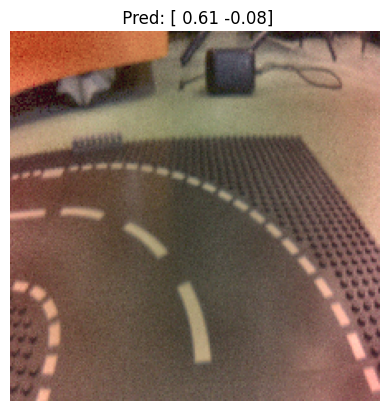

In [58]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Load image
image_path = 'camera/2.png'
image = cv2.imread(image_path)
if image is None:
    image_path = 'camera/1.jpg'
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found in camera/ directory!")

# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to PIL Image
image = Image.fromarray(image)

# Preprocess
preprocess = transforms.Compose([
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((224, 224)),  # adjust size to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

tensor_img = preprocess(image).unsqueeze(0)  # shape: (1, C, H, W)

# Visualize predictions
visualize_predictions(model, tensor_img)
